# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import logging 
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from tqdm.autonotebook import tqdm

import core.signal_processing as sigp
import helpers.dbg as dbg
import helpers.env as env
import helpers.printing as pri
import helpers.s3 as hs3
import vendors.kibot.utils as kut
import vendors.particle_one.price_movement_analysis as pma
import vendors.cme.read as cmer

/wd/julia/.conda/envs/p1_develop/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
print(env.get_system_signature())

pri.config_notebook()

dbg.init_logger(verb=logging.INFO)

_LOG = logging.getLogger(__name__)

# Packages
         python: 3.7.3
         joblib: 0.14.0
          numpy: 1.17.2
         pandas: 0.25.1
        pyarrow: 0.15.0
          scipy: 1.3.1
        seaborn: 0.9.0
        sklearn: 0.21.3
    statsmodels: 0.10.1
# Last commits:
  *   f61a82a Julia    Merge remote-tracking branch 'origin/master' into PartTask218_PRICE_Large_price_movement_analysis (   9 hours ago) Mon Oct 14 13:36:44 2019  (HEAD -> PartTask218_PRICE_Large_price_movement_analysis)
  |\  
  | * c171df8 saggese  Refactor pandoc toolchain: no functional change                   (  27 hours ago) Sun Oct 13 19:51:29 2019  (origin/master, origin/HEAD)
  | * f526793 saggese  Small improvements to the doc                                     (  27 hours ago) Sun Oct 13 19:36:56 2019           


# Load CME metadata

In [4]:
product_list = cmer.read_product_specs()

Reading s3://default00-bucket/cme/product_slate_export_with_contract_specs_20190905.csv


In [5]:
product_list.head()

,Clearing,Globex,Floor,Clearport,Product Name,Product Group,Sub Group,Category,Sub Category,Cleared As,Exchange,Volume,Open Interest,product_link,Contract Unit,Price Quotation,Trading Hours,Minimum Price Fluctuation,Product Code,Listed Contracts,Settlement Method,Termination Of Trading,Settlement Procedures,Position Limits,Exchange Rulebook,Block Minimum,Price Limit Or Circuit,All Or None Minimum,Vendor Codes,Settlement Procedures Link,Position Limits Link,Exchange Rulebook Link,Block Minimum Link,Price Limit Or Circuit Link,All Or None Minimum Link,Vendor Codes Link,Delivery Procedure,Last Delivery Date,Grade And Quality,Trade At Marker Or Trade At Settlement Rules,Delivery Period,Minimum Price Fluctuation_0,Grade And Quality Link,Floating Price,Days Or Hours,Trading Hours_0,Delivery Period Link,Delivery Procedure Link,Trade At Marker Or Trade At Settlement Rules Link,Minimum Price Fluctuation Link,Listed Contracts Link,Termination Of Trading_0,Termination Of Trading Link,Reportable Positions,Termination Of Trading_1,CME Globex:,Reportable Positions Link
0,ED,GE,NaN,ED,Eurodollar Futures,Interest Rate,Stirs,NaN,NaN,Futures,CME,3104281,13213901,http://www.cmegroup.com/trading/interest-rates...,"$2,500 x Contract IMM Index",Contract IMM Index = 100 minus R R = three-mon...,SUN - FRI: 5:00 p.m. - 4:00 p.m. CT,Nearest expiring contract month: One quarter o...,CME Globex: GECME ClearPort: EDClearing: ED,"Nearest 40 months (i.e., 10 years) in the Marc...",Financially Settled,Second London bank business day before 3rd Wed...,Eurodollar Future Settlement Procedures,CME Position Limits,CME 452,Block Minimum Thresholds,Price Limits,All or None Minimums,Quote Vendor Symbols Listing,http://www.cmegroup.com/confluence/display/EPI...,http://www.cmegroup.com/rulebook/files/positio...,http://www.cmegroup.com/rulebook/CME/V/450/452...,http://www.cmegroup.com/clearing/trading-pract...,http://www.cmegroup.com/rulebook/files/special...,http://www.cmegroup.com/clearing/trading-pract...,http://www.cmegroup.com/tools-information/vend...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,ZF,NaN,25,5-Year T-Note Futures,Interest Rate,US Treasury,NaN,NaN,Futures,CBOT,1166719,4162661,http://www.cmegroup.com/trading/interest-rates...,"Face value at maturity of $100,000",Points and fractions of points with par on the...,SUN - FRI: 5:00 p.m. - 4:00 p.m.,One-quarter of one thirty-second (1/32) of one...,CME Globex: ZFCME ClearPort: 25Clearing: 25,The first three consecutive contracts in the M...,Deliverable,Last business day of the calendar month. Tradi...,Treasury Settlement Procedures,CBOT Position Limits,CBOT 20,Block Minimum Thresholds,Price Limits,All or None Minimums,Quote Vendor Symbols Listing,http://www.cmegroup.com/confluence/display/EPI...,http://www.cmegroup.com/rulebook/files/positio...,https://www.cmegroup.com/rulebook/CBOT/II/20.pdf,http://www.cmegroup.com/clearing/trading-pract...,http://www.cmegroup.com/rulebook/files/special...,/clearing/trading-practices/all-or-none.html,http://www.cmegroup.com/tools-information/vend...,Federal Reserve book-entry wire-transfer system.,Third business day following the last trading ...,U.S. Treasury notes with an original term to m...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21,ZN,NaN,21,10-Year T-Note Futures,Interest Rate,US Treasury,NaN,NaN,Futures,CBOT,2181982,3656744,http://www.cmegroup.com/trading/interest-rates...,"Face value at maturity of $100,000",Points and fractions of points with par on the...,Sunday - Friday 6:00 p.m. - 5:00 p.m. (5:00 p....,Outrights: One-half of one thirty-second (1/32...,CME Globex: ZNCME ClearPort: 21Clearing: 21,"Quarterly contracts (Mar, Jun, Sep, Dec) liste...",Deliverable,Trading terminates on the seventh business day...,Treasury Settlement Procedures,CBOT Position Limits,CBOT Chapter 19,Block Minimum Thresholds,Price Limits,All or None Minimums,Quote Vendor Symbols Listing,http://www.cmegroup.com/

In [6]:
product_list["Product Group"].value_counts()

Energy           892
Equities         100
Agriculture       57
FX                55
Metals            44
Interest Rate     30
Name: Product Group, dtype: int64

In [7]:
product_list.set_index("Product Group", inplace=True)

In [8]:
commodity_groups = ["Energy", "Agriculture", "Metals"]

In [9]:
commodity_symbols = {
    group: product_list.loc[group]["Globex"].values for group in commodity_groups
}

In [10]:
commodity_symbols

{'Energy': array(['CL', 'NG', 'NN', 'N9L', 'D2L', 'HO', 'RB', 'H2L', 'HH', 'BZ',
        'V3L', 'BK', 'CSX', 'HTT', 'B0', 'NPG', 'WTT', 'B6L', 'E4L', 'HP',
        'AL1', 'AFF', 'EJL', 'LT', 'AD0', 'A1R', 'R7L', 'D4L', 'AW6', 'CU',
        'ADB', 'AC0', 'L3L', 'A4P', 'ME', 'CY', 'WOL', 'A8K', 'T7K', 'ZGL',
        'MTF', 'LPS', 'T3L', 'AE5', 'AYV', 'MFB', 'AU6', 'RBB', 'AWJ',
        'POL', 'A7Q', 'IDL', 'PWL', 'AZ9', 'RVR', 'ZJL', 'TL', 'A46', 'GZ',
        'RLX', 'K4L', 'FTL', 'HOB', 'GCU', 'CRB', 'WCW', 'AOL', 'JDL',
        'EN', 'AA6', 'PD', 'AGA', 'FO', 'N1B', 'NOI', 'MPX', 'NHN', 'NL',
        'JKM', 'MTS', 'AB3', 'NR', 'AH3', 'AP8', 'A7E', 'PGN', 'AFH',
        'AZ1', 'A8I', 'MNC', 'UV', 'SE', 'MAF', 'B7H', 'J4L', 'AYX', 'QM',
        'D3L', 'IN', 'MEO', 'QG', 'EXR', 'PM', 'TTF', 'MFF', 'PGG', 'D7L',
        'BOO', 'MXB', 'EVC', 'A5C', 'AA8', 'EWG', 'HB', 'A8O', 'RKA',
        'ARE', 'GCI', 'A1M', 'AL6', 'A1L', 'A0D', 'MBR', 'APS', 'N3L',
        'JET', 'VR', 'A9N', 'PH', 'PEL'

# Daily price movements

## Load kibot commodity daily prices

In [11]:
daily_metadata = kut.read_metadata2()
daily_metadata.head(3)

,Symbol,Link,Description
All_Futures_Contracts_daily.csv,,,
1,JY,http://api.kibot.com/?action=download&link=151...,CONTINUOUS JAPANESE YEN CONTRACT
2,JYF18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN JANUARY 2018
3,JYF19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN JANUARY 2019


In [12]:
len(daily_metadata["Symbol"])

14962

In [13]:
daily_metadata["Symbol"].nunique()

14962

In [14]:
len(commodity_symbols["Energy"])

892

In [15]:
energy_symbols_kibot = np.intersect1d(
    daily_metadata["Symbol"].values, commodity_symbols["Energy"]
)
energy_symbols_kibot

array(['ALM', 'BB', 'BZ', 'CCM', 'CL', 'FRC', 'HO', 'IN', 'JE', 'LL',
       'ME', 'MME', 'NG', 'NN', 'PM', 'QG', 'QM', 'RB', 'STS', 'TC', 'TL',
       'TM', 'TW'], dtype=object)

In [16]:
len(energy_symbols_kibot)

23

In [17]:
commodity_symbols_kibot = {
    group: np.intersect1d(
        daily_metadata["Symbol"].values, commodity_symbols[group]
    )
    for group in commodity_symbols.keys()
}

In [18]:
commodity_symbols_kibot

{'Energy': array(['ALM', 'BB', 'BZ', 'CCM', 'CL', 'FRC', 'HO', 'IN', 'JE', 'LL',
        'ME', 'MME', 'NG', 'NN', 'PM', 'QG', 'QM', 'RB', 'STS', 'TC', 'TL',
        'TM', 'TW'], dtype=object),
 'Agriculture': array(['GF', 'HE', 'LE', 'TT', 'ZCT', 'ZLT', 'ZMT', 'ZWT'], dtype=object),
 'Metals': array(['GC', 'GCK', 'HG', 'HGT', 'MGC', 'PA', 'PL', 'QC', 'QI', 'QO',
        'SI', 'SIL', 'UX'], dtype=object)}

In [19]:
{
    group: len(commodity_symbols_kibot[group])
    for group in commodity_symbols_kibot.keys()
}

{'Energy': 23, 'Agriculture': 8, 'Metals': 13}

In [20]:
comm_list = []
for comm_group in commodity_symbols_kibot.values():
    comm_list.extend(list(comm_group))
comm_list[:5]

['ALM', 'BB', 'BZ', 'CCM', 'CL']

In [21]:
s3_path = hs3.get_path()
kibot_path = os.path.join(s3_path, "kibot/All_Futures_Continuous_Contracts_daily/%s.csv.gz")

daily_price_dict_df = kut.read_multiple_symbol_data(
    comm_list, kibot_path, nrows=None
)

daily_price_dict_df["CL"].tail(2)

args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/ALM.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/BB.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/BZ.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/CCM.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/CL.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/FRC.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/HO.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/IN.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/JE.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/LL.cs

,open,high,low,close,vol
date,,,,,
2019-07-18,56.72,57.45,54.85,55.42,764491
2019-07-19,55.84,56.49,55.12,55.76,710948


## Largest movements for a specific symbol

In [22]:
symbol = "CL"

In [23]:
top_daily_movements_cl = pma.get_top_movements_for_symbol(daily_price_dict_df, symbol, 'daily')
top_daily_movements_cl.head()

date
2014-12-01    3.606042
2001-11-16    3.548594
2002-03-18    3.467714
2001-09-25    3.415421
2001-09-14    3.312830
Name: ret_0, dtype: float64

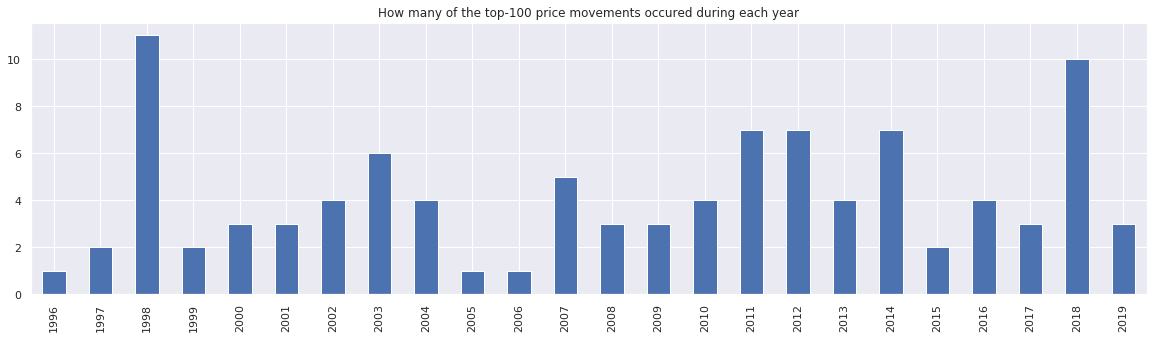

In [24]:
top_daily_movements_cl.index.year.value_counts(sort=False).plot(kind="bar")
plt.title("How many of the top-100 price movements occured during each year")
plt.show()

## Largest movement for energy group

In [25]:
group = "Energy"

In [26]:
commodity_symbols_kibot[group]

array(['ALM', 'BB', 'BZ', 'CCM', 'CL', 'FRC', 'HO', 'IN', 'JE', 'LL',
       'ME', 'MME', 'NG', 'NN', 'PM', 'QG', 'QM', 'RB', 'STS', 'TC', 'TL',
       'TM', 'TW'], dtype=object)

In [27]:
pma.get_top_movements_by_group(
    daily_price_dict_df, commodity_symbols_kibot, group, 'daily'
)

date
2016-03-04         inf
2016-03-16         inf
2008-04-07         inf
2016-02-17         inf
2016-02-19         inf
2008-02-19         inf
2016-02-25         inf
2016-03-02         inf
2017-03-20         inf
2016-03-09         inf
2016-03-10         inf
2016-03-11         inf
2016-03-17         inf
1999-03-11    2.572095
1996-01-08    2.518336
1995-12-11    2.285279
1998-03-19    2.251804
2004-11-25    2.224038
1998-01-27    2.189276
2011-08-05    2.073438
1997-09-26    2.064404
1996-01-12    2.048205
1996-05-24    2.025408
1997-08-05    2.007946
2002-05-16    2.006559
2010-11-28    1.982404
1995-12-05    1.960390
1997-09-29    1.932066
1999-05-07    1.921030
1995-11-03    1.874681
1998-03-17    1.872827
1998-09-11    1.869164
1995-12-19    1.848931
1996-10-04    1.838519
1997-10-07    1.837312
1997-05-19    1.801880
2008-09-30    1.799340
1998-07-22    1.789856
2002-12-13    1.780252
1998-12-18    1.779402
1996-02-14    1.778150
1998-08-11    1.775876
2003-06-27    1.754280
1999-0

## Largest movements for each group

In [28]:
top_100_daily_movements_by_group = {
    group: pma.get_top_movements_by_group(
        daily_price_dict_df, commodity_symbols_kibot, group, 'daily'
    )
    for group in tqdm(commodity_symbols_kibot.keys())
}

In [29]:
{
    group: head_prices_group.head(15)
    for group, head_prices_group in top_100_daily_movements_by_group.items()
}

{'Energy': date
 2016-03-04         inf
 2016-03-16         inf
 2008-04-07         inf
 2016-02-17         inf
 2016-02-19         inf
 2008-02-19         inf
 2016-02-25         inf
 2016-03-02         inf
 2017-03-20         inf
 2016-03-09         inf
 2016-03-10         inf
 2016-03-11         inf
 2016-03-17         inf
 1999-03-11    2.572095
 1996-01-08    2.518336
 dtype: float64, 'Agriculture': date
 2019-07-19    inf
 2017-10-19    inf
 2015-07-27    inf
 2015-07-23    inf
 2017-09-28    inf
 2015-07-17    inf
 2015-07-06    inf
 2015-06-19    inf
 2017-11-28    inf
 2017-09-22    inf
 2017-12-22    inf
 2018-02-08    inf
 2018-02-12    inf
 2018-02-20    inf
 2018-02-22    inf
 dtype: float64, 'Metals': date
 2019-05-15    inf
 2014-11-03    inf
 2019-04-01    inf
 2014-08-25    inf
 2019-05-17    inf
 2019-03-20    inf
 2019-03-05    inf
 2019-01-29    inf
 2019-03-25    inf
 2019-06-10    inf
 2019-07-05    inf
 2019-04-03    inf
 2019-04-05    inf
 2015-09-18    inf
 201

# 1-minute price movements

## Load 1-minute prices

In [30]:
minutely_metadata = kut.read_metadata1()

In [31]:
minutely_metadata.head()

,Symbol,Link,Description
All_Futures_Contracts_1min.csv,,,
1,JY,http://api.kibot.com/?action=download&link=151...,CONTINUOUS JAPANESE YEN CONTRACT
2,JYF18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN JANUARY 2018
3,JYF19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN JANUARY 2019
4,JYG18,http://api.kibot.com/?action=download&link=vrv...,JAPANESE YEN FEBRUARY 2018
5,JYG19,http://api.kibot.com/?action=download&link=8r8...,JAPANESE YEN FEBRUARY 2019


In [32]:
np.array_equal(
    minutely_metadata["Symbol"].values, minutely_metadata["Symbol"].values
)

True

In [ ]:
s3_path = hs3.get_path()
kibot_path = os.path.join(s3_path, "kibot/All_Futures_Continuous_Contracts_1min/%s.csv.gz")

minutely_price_dict_df = kut.read_multiple_symbol_data(
    comm_list, kibot_path, nrows=None
)

daily_price_dict_df["CL"].tail(2)

args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/ALM.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/BB.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/BZ.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/CCM.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/CL.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/FRC.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/HO.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/IN.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/JE.csv.gz', None) kwargs={}
args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/LL.csv.gz', Non

In [ ]:
minutely_price_dict_df["CL"].head()

In [ ]:
# five_min_price_dict_df = {
#     symbol: minutely_price_dict_df[symbol].resample("5Min").sum()
#     for symbol in minutely_price_dict_df.keys()
# }

## Top movements for a symbol

In [ ]:
symbol = "CL"

In [ ]:
top_100_movements_cl_1_min = pma.get_top_movements_for_symbol(
    minutely_price_dict_df, symbol, 'minutely'
)

In [ ]:
top_100_movements_cl_1_min.head()

In [ ]:
# top_100_movements_cl_5_min = pma.get_top_movements_for_symbol(
#     five_min_price_dict_df, symbol
# )

In [ ]:
# top_100_movements_cl_5_min.head()

In [ ]:
top_100_movements_cl_1_min.plot(kind="bar")
plt.title(
    f"Largest price movements in a 1 min interval (in z-score space) for {symbol} symbol"
)
plt.show()

In [ ]:
print(f"Top 100 of the price movements for {symbol} occur at the following time:")
print(pd.Series(top_100_movements_cl_1_min.index).dt.time.value_counts())

## Largest movements for energy group

In [ ]:
group = "Energy"

In [ ]:
commodity_symbols_kibot[group]

In [ ]:
pma.get_top_movements_by_group(
    minutely_price_dict_df, commodity_symbols_kibot, group, 'minutely'
)

## Largest movements for each group

In [ ]:
top_100_1_min_movements_by_group = {
    group: pma.get_top_movements_by_group(
        minutely_price_dict_df, commodity_symbols_kibot, group, 'minutely'
    )
    for group in tqdm(commodity_symbols_kibot.keys())
}

In [ ]:
{
    group: head_prices_group.head()
    for group, head_prices_group in top_100_1_min_movements_by_group.items()
}